# Z3 SAT Exercises

> Before trying to solve the exercises contained in this notebook, the reader is suggested to have gained experience with the tool through the `Tutorial.ipynb` notebook.

In [1]:
from itertools import combinations
from z3 import *
from utils import *
import numpy as np

## Useful contraints

In [2]:
def at_least_one(bool_vars):
    return Or(bool_vars)

def at_most_one(bool_vars):
    return [Not(And(a,b)) for a, b in combinations(bool_vars, 2)]

def exactly_one(bool_vars):
    out_constraints = at_most_one(bool_vars)
    out_constraints.append(at_least_one(bool_vars))
    return out_constraints

## Knights and Knaves

In [3]:
# Which are the variables?

# A holds if A is a knight, otherwise, A is a knave.
A = Bool('A')
B = Bool('B')

# Instantiation of the solver
s = Solver()

# Encode A's statement
statement = Or(Not(A), B)

# Now we start adding constraints

# If A is a knight, then A's statement is true
s.add(Implies(A, statement))

# If A is a knave, then A's statement is a lie
s.add(Implies(Not(A), Not(statement)))

# Unicity check
# s.add(Not(And(AisKnight, BisKnight)))

# Check model is sat
if s.check() == sat:
    print(s.model())
else:
    print("Not sat")

[A = True, B = True]


## Coloring graph

Another famous problem is the [coloring graph](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjAlpGV4az2AhUP2aQKHY_5BQwQFnoECAQQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FGraph_coloring&usg=AOvVaw0F_XS2AN3uz4G-IJx5Q8j0). 

Given a graph $({v_1,...,v_n},E)$ and $d$ colors, we need to assign a color to each vertex, s.t. if $(v_i,v_j) ∈ E$ then color of $v_i$ is different from color of $v_j$. 

In [4]:
def coloring_graph_sat(n, d, E):
    
    s = Solver()    # Solver instance

    # Get an array of variables where v_i_j holds if the vertex v_i has color j
    v = [[Bool(f"x_{i}_{j}") for j in range(d)] for i in range(n)]
    
    # Each vertex has at least one color 
    for i in range(n):
        s.add(at_least_one(v[i]))
    
    # Each edge must have different colors in its vertices
    for i, j in E:
        for k in range(d):
            s.add(Not(And(v[i][k], v[j][k])))
    
    # Check model
    if s.check() == sat:
        m = s.model()
        return [(i,j) for j in range(d) for i in range(n) if m.evaluate(v[i][j])]
    else:
        print("Not sat")
        return 

In [5]:
instance1 = {
        "n" : 5,
        "d": 3,
        "E" : [
            (0, 2),
            (0, 4),
            (1, 2),
            (1, 4),
            (2, 3), 
            (3, 4)
        ]
    }
instance2 = {
        "n":10,
        "d":3,
        "E":[
            (0, 1),
            (0, 4),
            (0, 5),
            (1, 2),
            (1, 6),
            (2, 7),
            (2, 3),
            (3, 8),
            (3, 4),
            (4, 9),
            (9, 6),
            (9, 7),
            (6, 8),
            (5, 7),
            (5, 8), 
        ]
}

In [6]:
instance = instance2

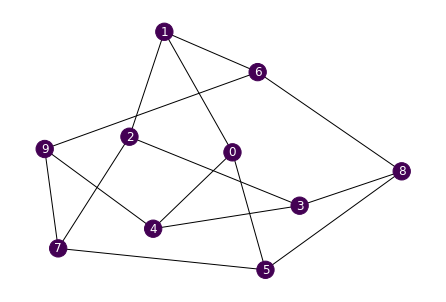

In [7]:
display_color_graph(E = instance["E"])

Wall time: 48 ms


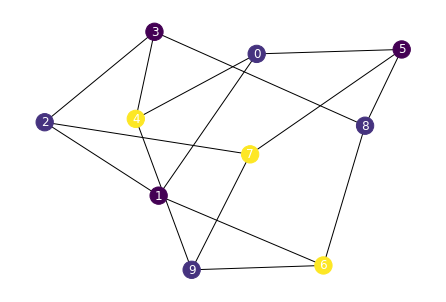

In [8]:
%%time
display_color_graph(sol = coloring_graph_sat(instance["n"], instance["d"], instance["E"]), E = instance["E"])

## N-Queens

The [n-queens problem](https://en.wikipedia.org/wiki/Eight_queens_puzzle) is the problem of placing n chess queens in a $nxn$ chessboard so that no two queens threaten each other. In light of this, the solution requires that no two queens share the same row, column, or diagonal.

In [9]:
def nqueens_sat(n):
    # Create all the variables
    c = [[Bool(f"c_{i}_{j}") for j in range(n)] for i in range(n)]

    # Create the solver instance
    s = Solver()

    # At least one on each row and column
    for i in range(n):
        s.add(at_least_one(c[i]))
        s.add(at_least_one([c[i][j] for j in range(n)]))

    # At most one on each row and column
    for i in range(n):
        s.add(at_most_one(c[i]))
        s.add(at_most_one([c[j][i] for j in range(n)]))

    # Add the diagonal constraints
    # I feel the names are a bit confusing, but all the diagonals are covered
    for i in range(n-1):

        # Define the arrays for each diagonal
        diag_ru = []
        diag_rl = []
        diag_lu = []
        diag_ll = []

        for j in range(n-i):
            diag_ru.append(c[n - 1 - (i + j)][n - 1 - j])
            diag_rl.append(c[n - 1 - (i + j)][j])
            diag_lu.append(c[i + j][j])
            diag_ll.append(c[i + j][n - 1 - j])
        
        s.add(at_most_one(diag_ru))
        s.add(at_most_one(diag_rl))
        s.add(at_most_one(diag_lu))
        s.add(at_most_one(diag_ll))
    
    # Check model 
    if s.check() == sat:
        m = s.model()
        return [(i,j) for j in range(n) for i in range(n) if m.evaluate(c[i][j])]
    else:
        print("Not sat")

In [10]:
%%time
display_nqueens(nqueens_sat(9))

. . . . . ♛ . . . 
. . . ♛ . . . . . 
. . . . . . . . ♛ 
. . . . ♛ . . . . 
. . . . . . . ♛ . 
. ♛ . . . . . . . 
. . . . . . ♛ . . 
. . ♛ . . . . . . 
♛ . . . . . . . . 
Wall time: 113 ms


## Sudoku

[Sudoku](https://en.wikipedia.org/wiki/Sudoku) is a logic-based, combinatorial number-placement puzzle. In classic sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid contain all of the digits from 1 to 9. 

In [11]:
# Sudoku instances, '0's correspond to empty cells

instance1 = ((0, 0, 0, 0, 9, 4, 0, 3, 0),
             (0, 0, 0, 5, 1, 0, 0, 0, 7),
             (0, 8, 9, 0, 0, 0, 0, 4, 0),
             (0, 0, 0, 0, 0, 0, 2, 0, 8),
             (0, 6, 0, 2, 0, 1, 0, 5, 0),
             (1, 0, 2, 0, 0, 0, 0, 0, 0),
             (0, 7, 0, 0, 0, 0, 5, 2, 0),
             (9, 0, 0, 0, 6, 5, 0, 0, 0),
             (0, 4, 0, 9, 7, 0, 0, 0, 0))

instance2 = ((0, 0, 0, 0, 9, 0, 1, 0, 0),
             (2, 8, 0, 0, 0, 5, 0, 0, 0),
             (7, 0, 0, 0, 0, 6, 4, 0, 0),
             (8, 0, 5, 0, 0, 3, 0, 0, 6),
             (0, 0, 1, 0, 0, 4, 0, 0, 0),
             (0, 7, 0, 2, 0, 0, 0, 0, 0),
             (3, 0, 0, 0, 0, 1, 0, 8, 0),
             (0, 0, 0, 0, 0, 0, 0, 5, 0),
             (0, 9, 0, 0, 0, 0, 0, 7, 0))

instance3 = ((0, 7, 0, 0, 0, 0, 0, 4, 9),
             (0, 0, 0, 4, 0, 0, 0, 0, 0),
             (4, 0, 3, 5, 0, 7, 0, 0, 8),
             (0, 0, 7, 2, 5, 0, 4, 0, 0),
             (0, 0, 0, 0, 0, 0, 8, 0, 0),
             (0, 0, 4, 0, 3, 0, 5, 9, 2),
             (6, 1, 8, 0, 0, 0, 0, 0, 5),
             (0, 9, 0, 1, 0, 0, 0, 3, 0),
             (0, 0, 5, 0, 0, 0, 0, 0, 7))

instance4 = ((0, 0, 0, 0, 0, 6, 0, 0, 0),
             (0, 5, 9, 0, 0, 0, 0, 0, 8),
             (2, 0, 0, 0, 0, 8, 0, 0, 0),
             (0, 4, 5, 0, 0, 0, 0, 0, 0),
             (0, 0, 3, 0, 0, 0, 0, 0, 0),
             (0, 0, 6, 0, 0, 3, 0, 5, 4),
             (0, 0, 0, 3, 2, 5, 0, 0, 6),
             (0, 0, 0, 0, 0, 0, 0, 0, 0),
             (0, 0, 0, 0, 0, 0, 0, 0, 0))

In [12]:
def sudoku_sat(instance):
    # All the variables we need: for each cell, nine variables that determine which digit must be assigned.
    v = [[[Bool(f"v_{i}_{j}_{k}") for k in range(9)] for j in range(9)] for i in range(9)]

    # Instance of the solver
    s = Solver()

    # A cell has only one value
    for i in range(9):
        for j in range(9):
            s.add(exactly_one([v[i][j][k] for k in range(9)]))
    
    # Each value is used only once in a row
    for i in range(9):
        for k in range(9):
            s.add(exactly_one([v[i][j][k] for j in range(9)]))
    
    # Each value used exactly once in each column
    for j in range(9):
        for k in range(9):
            s.add(exactly_one([v[i][j][k] for i in range(9)]))

    # Each value used exactly once in each 3x3 grid.
    for i in range(3):
        for j in range(3):
            for k in range(9):
                s.add(exactly_one([v[3*i+r][3*j+s][k] for r in range(3) for s in range(3)]))

    # Some numbers are already available
    for i in range(9):
        for j in range(9):
            if instance[i][j] != 0:
                val = instance[i][j] - 1    # Substract one to deal with indexes
                s.add(v[i][j][val])

    # Check model 
    if s.check() == sat:
        m = s.model()

        # Reconstruct solution from the boolean variables
        sol = np.array([k+1 for i in range(9) for j in range(9) for k in range(9) if m.evaluate(v[i][j][k])])
        sol = sol.reshape((9,9))    # Reshape list of values into an array of 9x9 dimensions
        
        return sol
    else:
        print("Not sat")

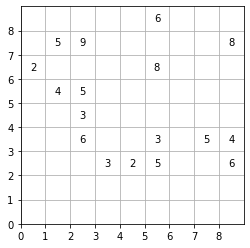

In [13]:
# Select the instance you want to solve
instance = instance4
display_sudoku(instance)

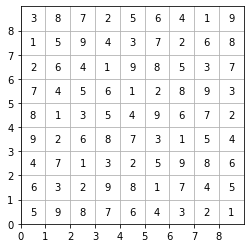

Wall time: 1.28 s


In [14]:
%%time
display_sudoku(sudoku_sat(instance))

## Nurse scheduling problem

In the next example, called [nurse scheduling problem](https://en.wikipedia.org/wiki/Nurse_scheduling_problem), a hospital supervisor needs to create a schedule for $n$ nurses over a fixed day period, subject to the following conditions:

- Each day is divided into three 8-hour shifts.
- Every day, each shift is assigned to a single nurse, and no nurse works more than one shift.
- Each nurse is assigned to a minimum amount of shifts during the given days period.


In [15]:
instance1 = {
    "num_nurses" : 4,
    "num_shifts" : 3,
    "num_days" : 3
}

instance2 = {
    "num_nurses" : 4,
    "num_shifts" : 3,
    "num_days" : 4
}

### Advanced useful contraints

In [16]:
def at_least_k_np(bool_vars, k):
    return at_most_k_np([Not(v) for v in bool_vars], len(bool_vars) - k)

def at_most_k_np(bool_vars, k):
    return And([Or([Not(v) for v in X]) for X in combinations(bool_vars, k+1)])

def exactly_k_np(bool_vars, k):
    return And(at_most_k_np(bool_vars, k), at_least_k_np(bool_vars, k))

I used morgan's law to turn:

$at\_most\_k(V,k) \equiv \bigwedge_{X \sube V} \bigvee_{v \in X} \lnot v \implies \bigwedge_{X \sube V} \lnot \bigwedge_{v \in X} v$

The rest of the constraints are easy to implement based on this one.

## Try it yourself!

Try to model the variables and constraints to solve the nurse scheduling problem, starting from the examples listed above. 

If possible, shifts should be distributed evenly and fairly, so that each nurse works the minimum amount of them. If this is not possible, because the total number of shifts is not divisible by the number of nurses, some nurses will be assigned one more shift, without crossing the maximum number of shifts which can be worked by each nurse

In [31]:
def nurse_scheduling_sat(num_nurses, num_shifts, num_days):
    # Create all the variables, shifts[i, j, k] is True if shift k is assigned to nurse i on day j.
    S = [[[Bool(f"s_{i}_{j}_{k}") for k in range(num_shifts)] for j in range(num_days)] for i in range(num_nurses)]
    
    # Solver instance
    s = Solver()

    # In each shift can work just one nurse
    for j in range(num_days):
        for k in range(num_shifts):
            s.add(exactly_one([S[i][j][k] for i in range(num_nurses)]))

    # Each nurse can work just one shift per day
    for i in range(num_nurses):
        for j in range(num_days):
            s.add(at_most_one(S[i][j]))
    
    # Fair assignment of shifts
    min_shifts_per_nurse = (num_shifts * num_days) // num_nurses
    if (num_days * num_shifts) % num_nurses == 0:
        max_shifts_per_nurse = min_shifts_per_nurse
    else:
        max_shifts_per_nurse = min_shifts_per_nurse + 1

    for i in range(num_nurses):
        shifts_worked = []
        for j in range(num_days):
            for k in range(num_shifts):
                shifts_worked.append(S[i][j][k])
        s.add(at_least_k_np(shifts_worked, min_shifts_per_nurse))
        s.add(at_most_k_np(shifts_worked, max_shifts_per_nurse))

    # Check model 
    if s.check() == sat:
        m = s.model()
        return [(i, j, k) for i in range(num_nurses) for j in range(num_days) for k in range(num_shifts) if m.evaluate(S[i][j][k])]
    else:
        print("Not sat")
    

In [32]:
instance = instance1

In [33]:
%%time
display_nurses_shifts(nurse_scheduling_sat(instance["num_nurses"], instance["num_shifts"], instance["num_days"]), instance["num_nurses"], instance["num_shifts"], instance["num_days"])

Day 0
  Nurse 0 works shift 0
  Nurse 1 does not work
  Nurse 2 works shift 2
  Nurse 3 works shift 1
Day 1
  Nurse 0 works shift 2
  Nurse 1 works shift 1
  Nurse 2 does not work
  Nurse 3 works shift 0
Day 2
  Nurse 0 works shift 2
  Nurse 1 works shift 1
  Nurse 2 works shift 0
  Nurse 3 does not work
Wall time: 223 ms


In [34]:
instance = instance2

In [36]:
%%time
display_nurses_shifts(nurse_scheduling_sat(instance["num_nurses"], instance["num_shifts"], instance["num_days"]), instance["num_nurses"], instance["num_shifts"], instance["num_days"])

Day 0
  Nurse 0 works shift 1
  Nurse 1 does not work
  Nurse 2 works shift 0
  Nurse 3 works shift 2
Day 1
  Nurse 0 does not work
  Nurse 1 works shift 1
  Nurse 2 works shift 0
  Nurse 3 works shift 2
Day 2
  Nurse 0 works shift 2
  Nurse 1 works shift 1
  Nurse 2 does not work
  Nurse 3 works shift 0
Day 3
  Nurse 0 works shift 2
  Nurse 1 works shift 1
  Nurse 2 works shift 0
  Nurse 3 does not work
Wall time: 475 ms
